# sim_study_block

## preamble

In [1]:
# importing numpy
import numpy as np
from numpy import random

In [2]:
# importing plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [3]:
# importing storage for results
import zarr

In [4]:
# importing pandas
import pandas as pd

## simulated data

In [5]:
# loading in functions for simulation
%run '../../function_scripts/model/UC_simulation.py'

In [6]:
# importing the csv - only the important columns
data_real = pd.read_csv("../../Antidote_household.csv", usecols=["hid","pid","date","age","sex","hiv","hivChild","cpt","result","week"])

# converting the pid to integers (and saving lists of sex and age)
pid_unique = []
no_individuals = 0
test_individuals = []
sex = []
age = []
for i in range(1659):
    pid = data_real['pid'][i]
    if pid in pid_unique:
        test_individuals.append(pid_unique.index(pid))
    else:
        pid_unique.append(pid)
        test_individuals.append(no_individuals)
        sex.append(data_real['sex'][i])
        age.append(data_real['age'][i])
        no_individuals += 1
sex = np.array(sex)
age = np.array(age)

# centring age and sex
age = age - np.mean(age)
sex = sex - np.mean(sex)

# calculating N and T
N = no_individuals
T = int(max(data_real['week']))

# making a test result matrix (for the real test results)
test_results_real = np.tile(np.nan,(T+1,N))
for i in range(1659):
    j = test_individuals[i]
    t = int(data_real['week'][i])
    test_results_real[t,j] = data_real['result'][i]

# converting the hid to integers
hid_unique = []
no_houses = 0
test_houses = []
for hid in data_real['hid'] :
    if hid in hid_unique:
        test_houses.append(hid_unique.index(hid))
    else:
        hid_unique.append(hid)
        test_houses.append(no_houses)
        no_houses += 1

# list of which house each individual is in
house_list = []
for i in range(N):
    test_no = test_individuals.index(i)
    house_list.append(test_houses[test_no])

# making a household mixing matrix
h = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if house_list[i]==house_list[j]:
            h[i,j] = 1

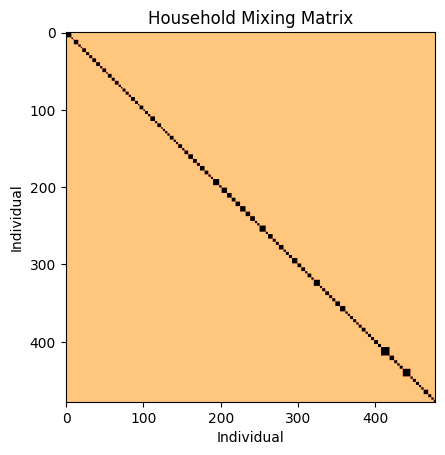

In [7]:
# plotting h
plt.imshow(h,cmap="copper_r")
plt.title("Household Mixing Matrix")
plt.ylabel("Individual")
plt.xlabel("Individual")
plt.show()

In [8]:
# true values of the paramters
theta = np.array([0.1,1.5,0,0])

In [9]:
# true values of other inputs
prop_0 = 0.3
gamma = 0.5
test_rate = 0.3 #will be replaced with other test data, but parameter needed for simulation
sens = 0.95
spec = 0.999

In [10]:
# seasonality modifiers
seasonality_mode = 2
seasonal_period = 52
t_ast = 17

# resulting matrices
seasonal_vector = np.array([1 - np.cos(2*np.pi*(t+t_ast)/seasonal_period) for t in range(T+1)])
seasonal_matrix_G = np.tile(seasonal_vector, (N,1)).T
seasonal_matrix_H = np.tile(1, (T+1,N))

In [11]:
# simulating the data
UC_results = UC_sim(N,h,age,sex,prop_0,theta,gamma,test_rate,sens,spec,T,seasonality_mode,seasonal_period,t_ast,1)

In [12]:
# creating a test result matrix
random.seed(256)
test_occurance = test_results_real*0 + 1
pos_prob = 0.9*UC_results['X'] + (1-0.99)*(1-UC_results['X'])
test_outcome = random.binomial(1,pos_prob)
test_results = test_outcome * test_occurance

/tmp/ipykernel_823593/4114825960.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(0, 0, "-", color=colour0, label="%d"%0, linestyle='', marker="s")
/tmp/ipykernel_823593/4114825960.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(0, 0, "-", color=colour1, label="%d"%1, linestyle='', marker="s")


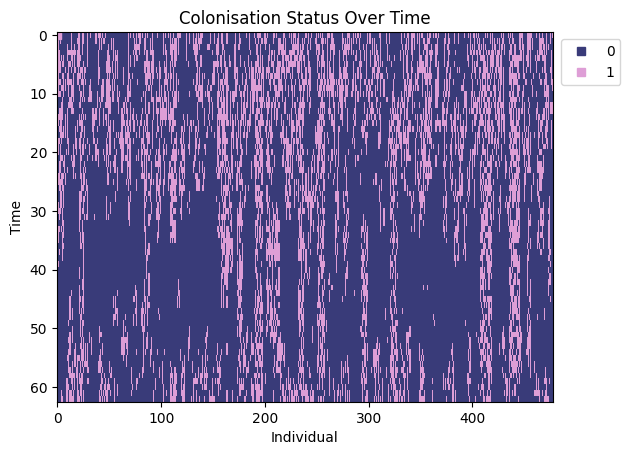

In [13]:
# plotting X
plt.imshow(UC_results['X'],cmap="tab20b",interpolation="nearest",aspect="auto")
#plt.colorbar()
colour0 = '#393b79'
plt.plot(0, 0, "-", color=colour0, label="%d"%0, linestyle='', marker="s")
colour1 = '#de9ed6'
plt.plot(0, 0, "-", color=colour1, label="%d"%1, linestyle='', marker="s")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0), scatterpoints=1)
plt.title(r'Colonisation Status Over Time')
plt.ylabel("Time")
plt.xlabel("Individual")
plt.show()

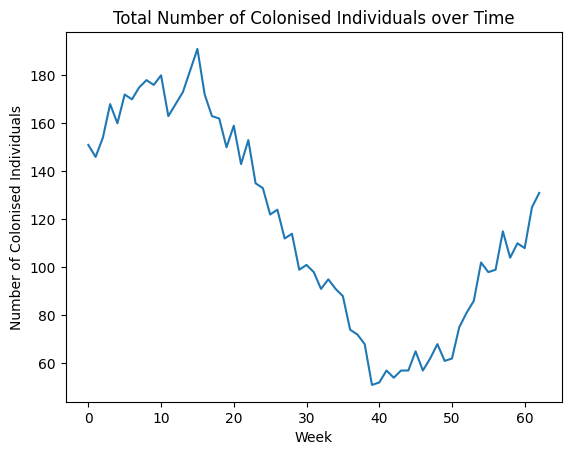

In [14]:
# plotting the number of colonised individuals over time
plt.plot(UC_results['sum_C'])
plt.title("Total Number of Colonised Individuals over Time")
plt.ylabel("Number of Colonised Individuals")
plt.xlabel("Week")
plt.show()

/tmp/ipykernel_823593/2414120816.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(0, 0, "-", color=colour0, label="0", linestyle='', marker="s")
/tmp/ipykernel_823593/2414120816.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(0, 0, "-", color=colour1, label="1", linestyle='', marker="s")
/tmp/ipykernel_823593/2414120816.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(0, 0, "-", color=colour2, label="NA", linestyle='', marker="s")


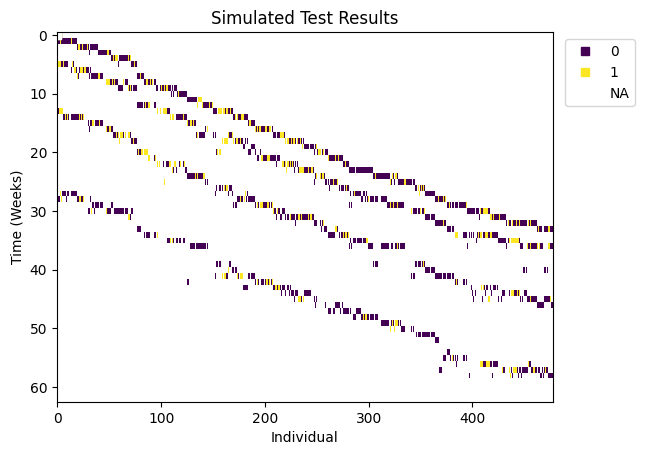

In [15]:
# looking at the test result matrix
plt.imshow(test_results,cmap="viridis",interpolation="nearest",aspect="auto")
colour0 = '#440154'
plt.plot(0, 0, "-", color=colour0, label="0", linestyle='', marker="s")
colour1 = '#fae622'
plt.plot(0, 0, "-", color=colour1, label="1", linestyle='', marker="s")
colour2 = '#ffffff'
plt.plot(0, 0, "-", color=colour2, label="NA", linestyle='', marker="s")
plt.legend(loc="upper right", bbox_to_anchor=(1.18, 1.0), scatterpoints=1)
plt.title(r'Simulated Test Results')
plt.ylabel("Time (Weeks)")
plt.xlabel("Individual")
plt.show()

In [16]:
# function to work out the number of TP/FP/TN/FNs
def test_acc(X:np.array,test_results:np.array) :
    
    # list of inputs:
    # X - matrix of all individuals colonisation status over time
    # test_results - matrix of all individuals colonisation status over time

    # creating a matrix comparing the results with the current latent variable values (0 for TPs or TNs, 1 for FPs, -1 for FNs, and nan for no tests)
    test_diff_matrix = test_results - X

    # calculating the number of TP/FP/TN/FNs from this matrix
    TP = np.sum((test_diff_matrix==0)*X)
    FN = np.sum(test_diff_matrix==-1)
    FP = np.sum(test_diff_matrix==1)
    TN = np.sum((test_diff_matrix==0)*(1-X))

    # returning outputs
    output = {'TP':TP, 'FN':FN, 'FP':FP, 'TN':TN}
    return output

In [17]:
# the number of TP/FP/TN/FNs
test_acc(UC_results['X'],test_results)

{'TP': 363, 'FN': 38, 'FP': 16, 'TN': 1156}

## inference information

In [18]:
# hyperparameters of priors
mu = np.array([0.001,0.001,0.001,0.001])
prior_X_0 = 0.3

In [19]:
# starting values
theta_start = np.array([0.5,0.5,0,0])
X_start = UC_sim(N,h,age,sex,prop_0,theta,gamma,test_rate,sens,spec,T,seasonality_mode,seasonal_period,t_ast,1)['X']
covariance_start = 0.000001*np.identity(4)
scaling = 0.9

In [20]:
# maximum block update size
m = 4

In [21]:
# MCMC iterations
K = 100000
K_latent = 400

## acceptance rates

In [23]:
# importing the saved acceptance rates
MCMC_noncentred_acc = zarr.open('./MCMC_output/acc.zarr', mode='r')

# printing the acceptance rates
print("acc_theta:", MCMC_noncentred_acc[0])
print("acc_initial:", MCMC_noncentred_acc[1])
print("acc_latent:", MCMC_noncentred_acc[2])

# removing the acceptance rates from memory
del(MCMC_noncentred_acc)

acc_theta: 0.31236
acc_initial: 0.44678
acc_latent: 0.43490485


## parameters

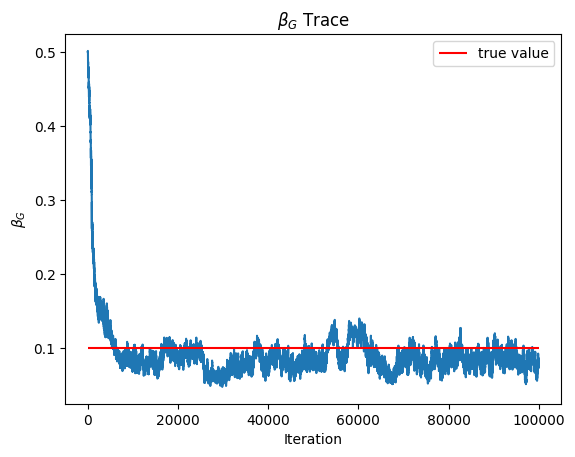

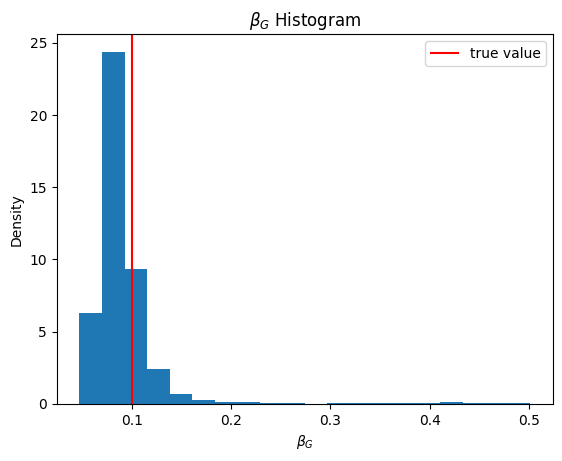

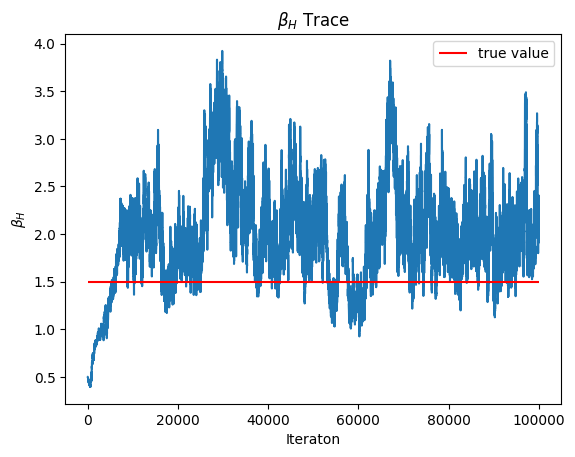

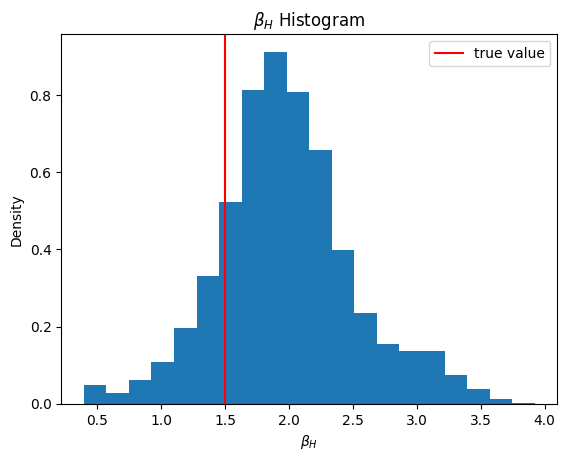

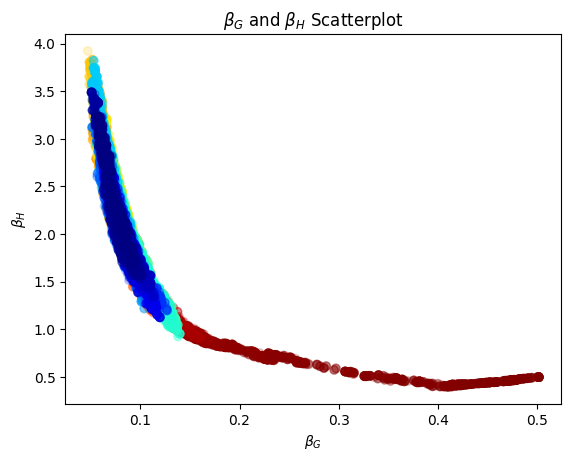

In [24]:
# importing the saved run of theta
MCMC_noncentred_theta = zarr.open('./MCMC_output/theta.zarr', mode='r')

# trace plot and histogram of beta_G
plt.plot(MCMC_noncentred_theta[:K,0])
plt.hlines(np.array(theta[0]),0,K,colors="red",label="true value")
plt.legend()
plt.title(r'$\beta_G$ Trace')
plt.xlabel("Iteration")
plt.ylabel(r'$\beta_G$')
plt.show()
plt.hist(MCMC_noncentred_theta[:K,0],density=1,bins=20)
plt.axvline(theta[0],color="red",label="true value")
plt.legend()
plt.title(r'$\beta_G$ Histogram')
plt.xlabel(r'$\beta_G$')
plt.ylabel("Density")
plt.show()

# trace plot and histogram of beta_H
plt.plot(MCMC_noncentred_theta[:K,1])
plt.hlines(np.array(theta[1]),0,K,colors="red",label="true value")
plt.legend()
plt.title(r'$\beta_{H}$ Trace')
plt.xlabel("Iteraton")
plt.ylabel(r'$\beta_{H}$')
plt.show()
plt.hist(MCMC_noncentred_theta[:K,1],density=1,bins=20)
plt.axvline(theta[1],color="red",label="true value")
plt.legend()
plt.title(r'$\beta_{H}$ Histogram')
plt.xlabel(r'$\beta_{H}$')
plt.ylabel("Density")
plt.show()

# correlation plot of beta_G vs beta_H
plt.scatter(MCMC_noncentred_theta[:K,0],MCMC_noncentred_theta[:K,1],alpha=0.2,color=plt.cm.jet(np.linspace(1,0,K)))
plt.title(r'$\beta_G \text{ and } \beta_{H}$ Scatterplot')
plt.xlabel(r'$\beta_G$')
plt.ylabel(r'$\beta_{H}$')
plt.show()

# removing the traces of theta from memory
del(MCMC_noncentred_theta)

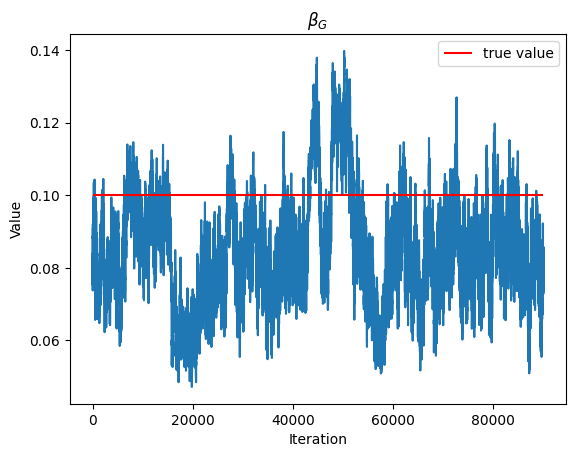

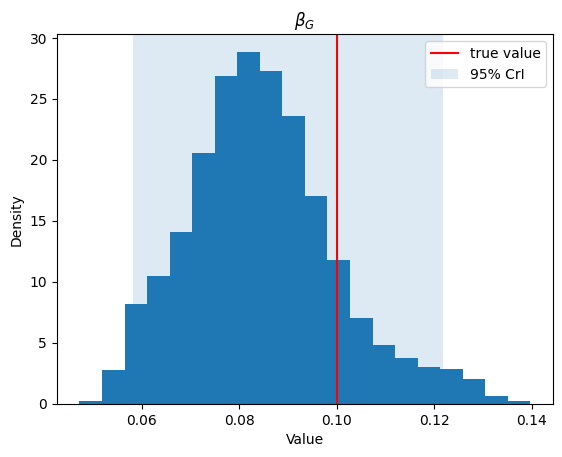

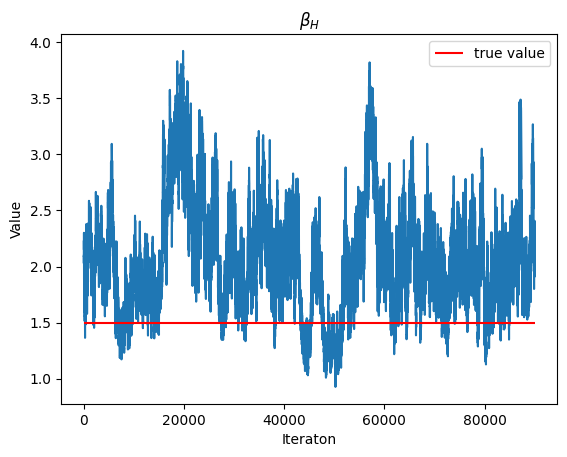

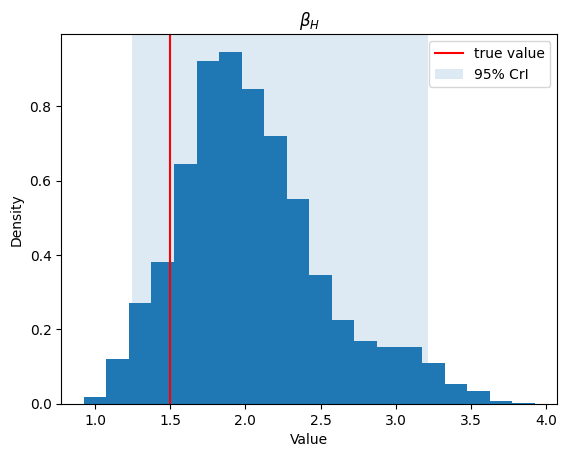

beta_G: [0.05812139 0.08358189 0.12173019]
beta_H: [1.24524733 1.97999314 3.21606863]


In [28]:
# importing the saved run of theta
MCMC_noncentred_theta = zarr.open('./MCMC_output/theta.zarr', mode='r')

# trace plot and histogram of beta_G
plt.plot(MCMC_noncentred_theta[10000:,0])
plt.hlines(np.array(theta[0]),0,K-10000,colors="red",label="true value")
plt.legend()
plt.title(r'$\beta_G$')
plt.xlabel("Iteration")
plt.ylabel("Value")
#plt.savefig("plots/beta_G_trace.pdf")
plt.show()
plt.hist(MCMC_noncentred_theta[10000:,0],density=1,bins=20)
plt.axvline(theta[0],color="red",label="true value")
plt.axvspan(np.quantile(MCMC_noncentred_theta[10000:,0],0.025),np.quantile(MCMC_noncentred_theta[10000:,0],0.975),alpha=0.15,label="95% CrI")
plt.legend()
plt.title(r'$\beta_G$')
plt.xlabel("Value")
plt.ylabel("Density")
#plt.savefig("plots/beta_G_hist.pdf")
plt.show()

# trace plot and histogram of beta_H
plt.plot(MCMC_noncentred_theta[10000:,1])
plt.hlines(np.array(theta[1]),0,K-10000,colors="red",label="true value")
plt.legend()
plt.title(r'$\beta_{H}$')
plt.xlabel("Iteraton")
plt.ylabel("Value")
#plt.savefig("plots/beta_H_trace.pdf")
plt.show()
plt.hist(MCMC_noncentred_theta[10000:,1],density=1,bins=20)
plt.axvline(theta[1],color="red",label="true value")
plt.axvspan(np.quantile(MCMC_noncentred_theta[10000:,1],0.025),np.quantile(MCMC_noncentred_theta[10000:,1],0.975),alpha=0.15,label="95% CrI")
plt.legend()
plt.title(r'$\beta_{H}$')
plt.xlabel("Value")
plt.ylabel("Density")
#plt.savefig("plots/beta_H_hist.pdf")
plt.show()

# correlation plot of beta_G vs beta_H
plt.scatter(MCMC_noncentred_theta[10000:,0],MCMC_noncentred_theta[10000:,1],alpha=0.2)
plt.scatter(theta[0],theta[1],color="red",label="true value")
plt.legend()
plt.title(r'$\beta_G \text{ and } \beta_{H}$ Scatterplot (Burn-in Removed)')
plt.xlabel(r'$\beta_G$')
plt.ylabel(r'$\beta_{H}$')
plt.show()

# median and 95% credible intervals
print("beta_G:", np.quantile(MCMC_noncentred_theta[10000:,0],[0.025,0.5,0.975]))
print("beta_H:", np.quantile(MCMC_noncentred_theta[10000:,1],[0.025,0.5,0.975]))

# removing the traces of theta from memory
del(MCMC_noncentred_theta)

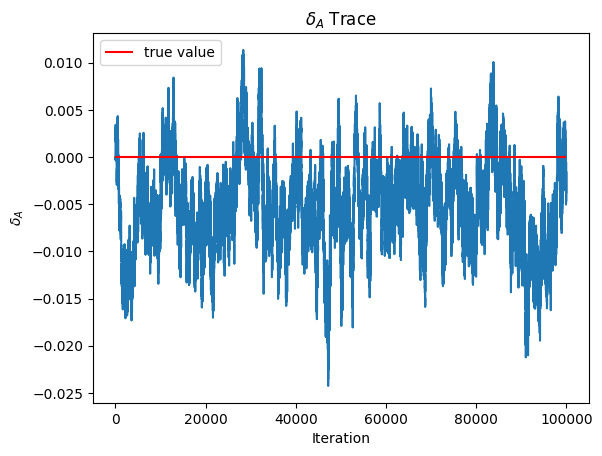

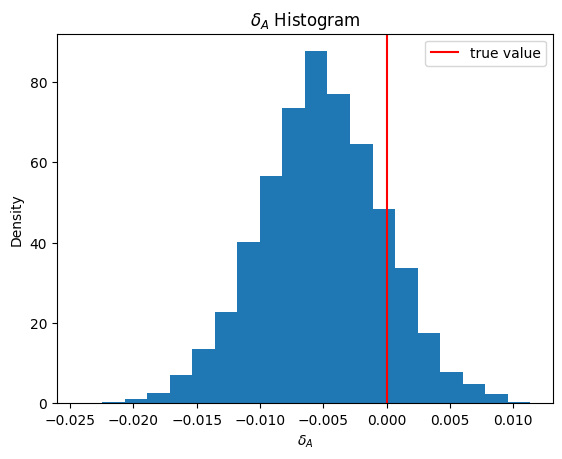

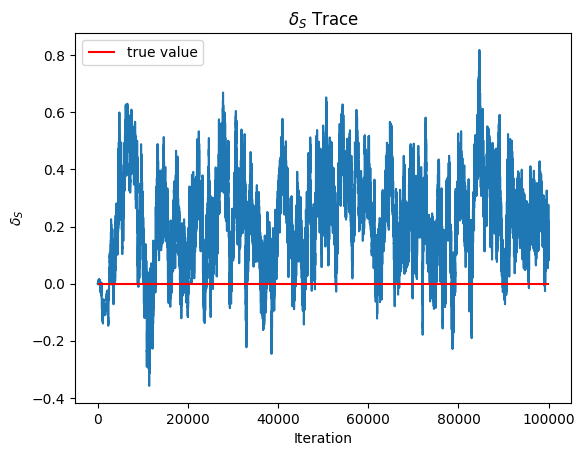

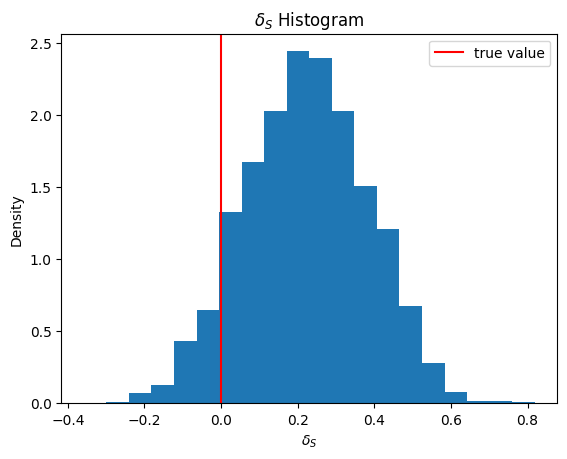

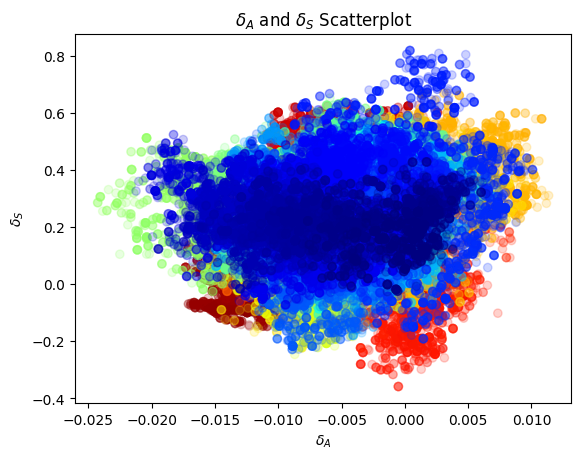

In [55]:
# importing the saved run of theta
MCMC_noncentred_theta = zarr.open('./MCMC_output/theta.zarr', mode='r')

# trace plot and histogram of delta_A
plt.plot(MCMC_noncentred_theta[:K,2])
plt.hlines(np.array(theta[2]),0,K,colors="red",label="true value")
plt.legend()
plt.title(r'$\delta_A$ Trace')
plt.xlabel("Iteration")
plt.ylabel(r'$\delta_A$')
plt.show()
plt.hist(MCMC_noncentred_theta[:K,2],density=1,bins=20)
plt.axvline(theta[2],color="red",label="true value")
plt.legend()
plt.title(r'$\delta_A$ Histogram')
plt.xlabel(r'$\delta_A$')
plt.ylabel("Density")
plt.show()

# trace plot and histogram of delta_S
plt.plot(MCMC_noncentred_theta[:K,3])
plt.hlines(np.array(theta[3]),0,K,colors="red",label="true value")
plt.legend()
plt.title(r'$\delta_S$ Trace')
plt.xlabel("Iteration")
plt.ylabel(r'$\delta_S$')
plt.show()
plt.hist(MCMC_noncentred_theta[:K,3],density=1,bins=20)
plt.axvline(theta[3],color="red",label="true value")
plt.legend()
plt.title(r'$\delta_S$ Histogram')
plt.xlabel(r'$\delta_S$')
plt.ylabel("Density")
plt.show()

# correlation plot of deltas
plt.scatter(MCMC_noncentred_theta[:K,2],MCMC_noncentred_theta[:K,3],alpha=0.2,color=plt.cm.jet(np.linspace(1,0,K)))
plt.title(r'$\delta_A \text{ and } \delta_S$ Scatterplot')
plt.xlabel(r'$\delta_A$')
plt.ylabel(r'$\delta_S$')
plt.show()

# removing the traces of theta from memory
del(MCMC_noncentred_theta)

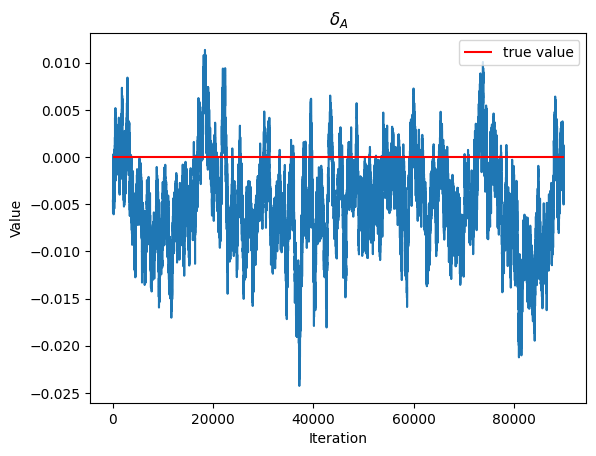

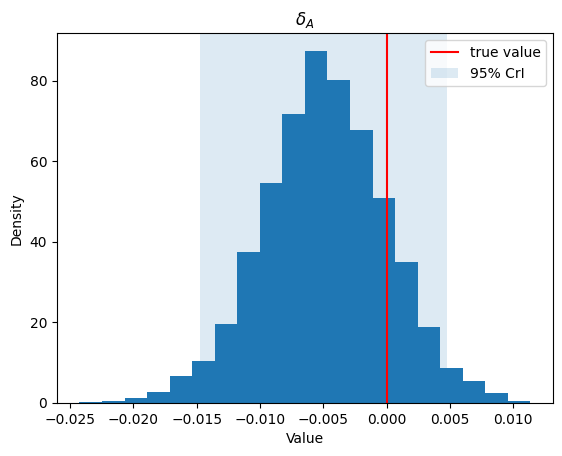

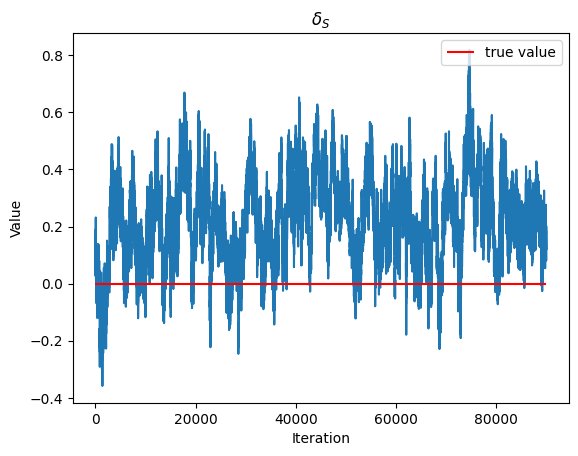

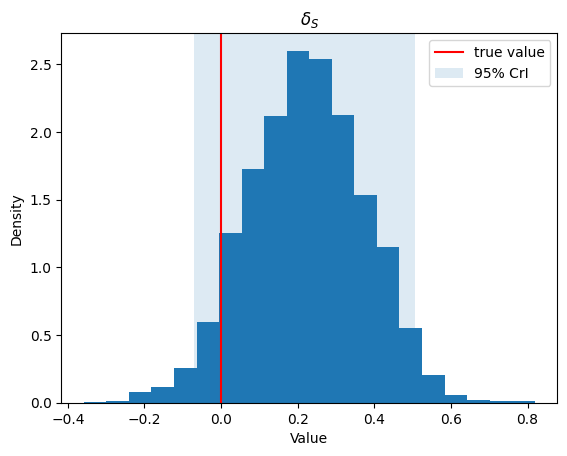

delta_A: [-0.01473199 -0.00490568  0.00480024]
delta_S: [-0.07170096  0.22390743  0.50702119]


In [32]:
# importing the saved run of theta
MCMC_noncentred_theta = zarr.open('./MCMC_output/theta.zarr', mode='r')

# trace plot and histogram of delta_A
plt.plot(MCMC_noncentred_theta[10000:,2])
plt.hlines(np.array(theta[2]),0,K-10000,colors="red",label="true value")
plt.legend(loc = "upper right")
plt.title(r'$\delta_A$')
plt.xlabel("Iteration")
plt.ylabel("Value")
#plt.savefig("plots/delta_A_trace.pdf")
plt.show()
plt.hist(MCMC_noncentred_theta[10000:,2],density=1,bins=20)
plt.axvline(theta[2],color="red",label="true value")
plt.axvspan(np.quantile(MCMC_noncentred_theta[10000:,2],0.025),np.quantile(MCMC_noncentred_theta[10000:,2],0.975),alpha=0.15,label="95% CrI")
plt.legend(loc = "upper right")
plt.title(r'$\delta_A$')
plt.xlabel("Value")
plt.ylabel("Density")
#plt.savefig("plots/delta_A_hist.pdf")
plt.show()

# trace plot and histogram of delta_S
plt.plot(MCMC_noncentred_theta[10000:,3])
plt.hlines(np.array(theta[3]),0,K-10000,colors="red",label="true value")
plt.legend(loc = "upper right")
plt.title(r'$\delta_S$')
plt.xlabel("Iteration")
plt.ylabel("Value")
#plt.savefig("plots/delta_S_trace.pdf")
plt.show()
plt.hist(MCMC_noncentred_theta[10000:,3],density=1,bins=20)
plt.axvline(theta[3],color="red",label="true value")
plt.axvspan(np.quantile(MCMC_noncentred_theta[10000:,3],0.025),np.quantile(MCMC_noncentred_theta[10000:,3],0.975),alpha=0.15,label="95% CrI")
plt.legend(loc = "upper right")
plt.title(r'$\delta_S$')
plt.xlabel("Value")
plt.ylabel("Density")
#plt.savefig("plots/delta_S_hist.pdf")
plt.show()

# correlation plot of deltas
plt.scatter(MCMC_noncentred_theta[10000:,2],MCMC_noncentred_theta[10000:,3],alpha=0.2)
plt.scatter(theta[2],theta[3],color="red",label="true value")
plt.legend()
plt.title(r'$\delta_A \text{ and } \delta_S$ Scatterplot (Burn-in Removed)')
plt.xlabel(r'$\delta_A$')
plt.ylabel(r'$\delta_S$')
plt.show()

# median and 95% credible intervals
print("delta_A:", np.quantile(MCMC_noncentred_theta[10000:,2],[0.025,0.5,0.975]))
print("delta_S:", np.quantile(MCMC_noncentred_theta[10000:,3],[0.025,0.5,0.975]))

# removing the traces of theta from memory
del(MCMC_noncentred_theta)

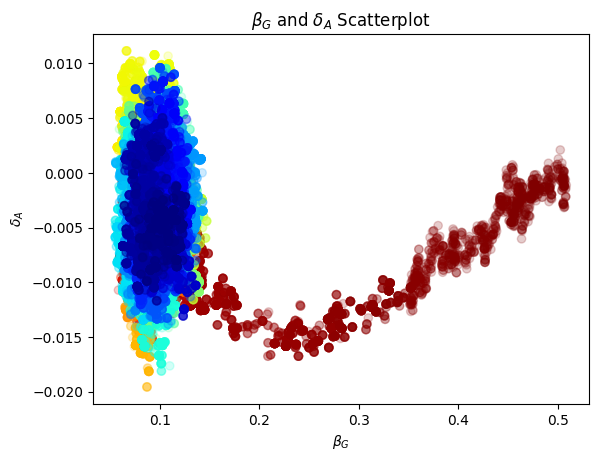

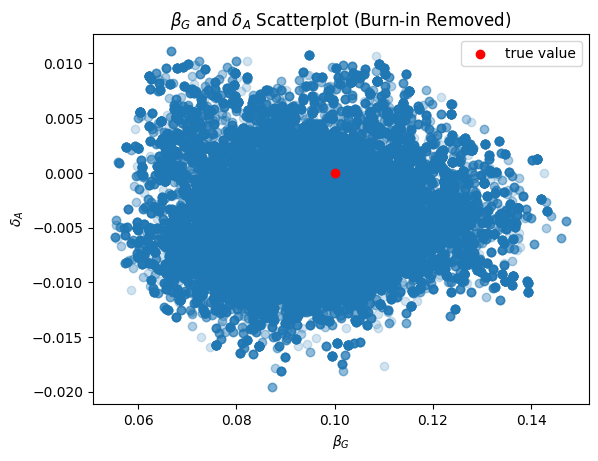

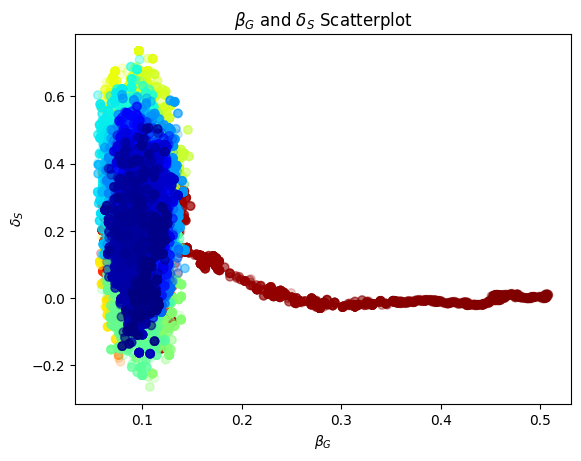

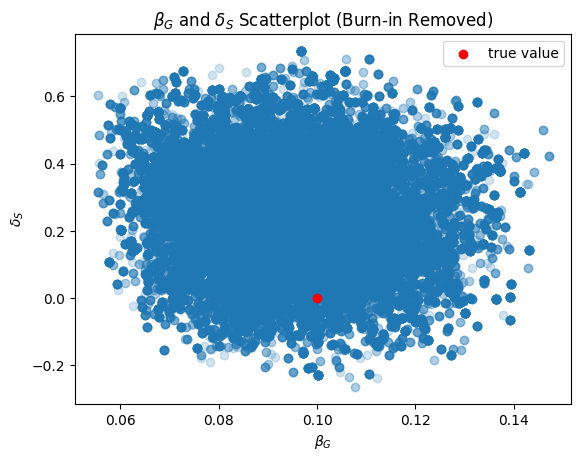

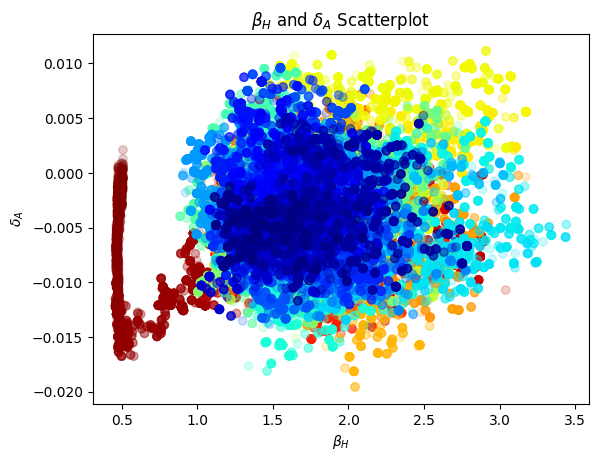

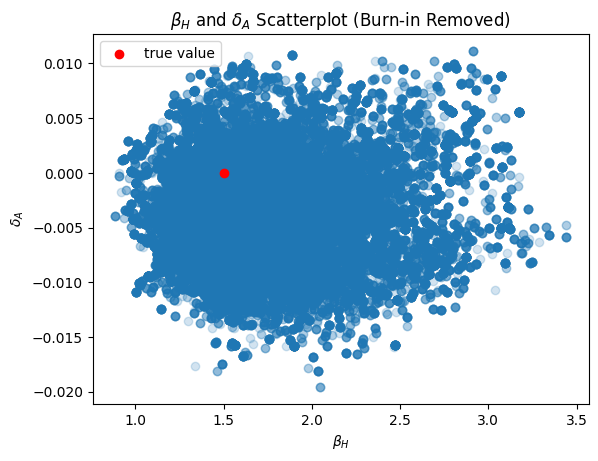

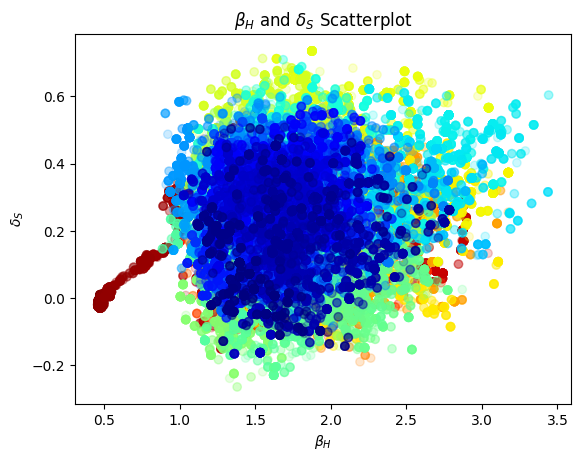

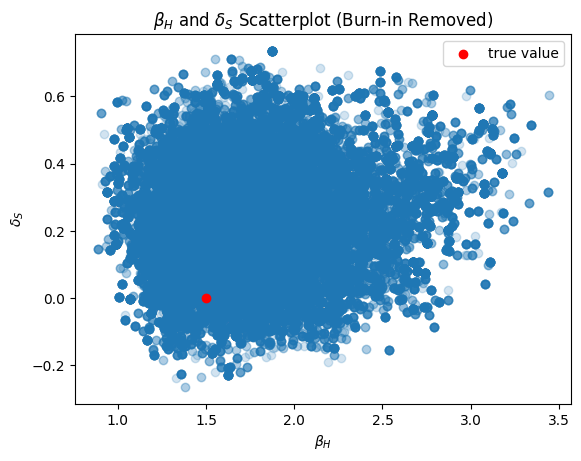

In [40]:
# importing the saved run of theta
MCMC_noncentred_theta = zarr.open('./MCMC_output/theta.zarr', mode='r')

# correlation plot of beta_G vs delta_A
plt.scatter(MCMC_noncentred_theta[:,0],MCMC_noncentred_theta[:,2],alpha=0.2,color=plt.cm.jet(np.linspace(1,0,K)))
plt.title(r'$\beta_G \text{ and } \delta_A$ Scatterplot')
plt.xlabel(r'$\beta_G$')
plt.ylabel(r'$\delta_A$')
plt.show()
plt.scatter(MCMC_noncentred_theta[5000:,0],MCMC_noncentred_theta[5000:,2],alpha=0.2)
plt.scatter(theta[0],theta[2],color="red",label="true value")
plt.legend()
plt.title(r'$\beta_G \text{ and } \delta_A$ Scatterplot (Burn-in Removed)')
plt.xlabel(r'$\beta_G$')
plt.ylabel(r'$\delta_A$')
plt.show()

# correlation plot of beta_G vs delta_S
plt.scatter(MCMC_noncentred_theta[:,0],MCMC_noncentred_theta[:,3],alpha=0.2,color=plt.cm.jet(np.linspace(1,0,K)))
plt.title(r'$\beta_G \text{ and } \delta_S$ Scatterplot')
plt.xlabel(r'$\beta_G$')
plt.ylabel(r'$\delta_S$')
plt.show()
plt.scatter(MCMC_noncentred_theta[5000:,0],MCMC_noncentred_theta[5000:,3],alpha=0.2)
plt.scatter(theta[0],theta[3],color="red",label="true value")
plt.legend()
plt.title(r'$\beta_G \text{ and } \delta_S$ Scatterplot (Burn-in Removed)')
plt.xlabel(r'$\beta_G$')
plt.ylabel(r'$\delta_S$')
plt.show()

# correlation plot of beta_H vs delta_A
plt.scatter(MCMC_noncentred_theta[:,1],MCMC_noncentred_theta[:,2],alpha=0.2,color=plt.cm.jet(np.linspace(1,0,K)))
plt.title(r'$\beta_H \text{ and } \delta_A$ Scatterplot')
plt.xlabel(r'$\beta_H$')
plt.ylabel(r'$\delta_A$')
plt.show()
plt.scatter(MCMC_noncentred_theta[5000:,1],MCMC_noncentred_theta[5000:,2],alpha=0.2)
plt.scatter(theta[1],theta[2],color="red",label="true value")
plt.legend()
plt.title(r'$\beta_H \text{ and } \delta_A$ Scatterplot (Burn-in Removed)')
plt.xlabel(r'$\beta_H$')
plt.ylabel(r'$\delta_A$')
plt.show()

# correlation plot of beta_H vs delta_S
plt.scatter(MCMC_noncentred_theta[:,1],MCMC_noncentred_theta[:,3],alpha=0.2,color=plt.cm.jet(np.linspace(1,0,K)))
plt.title(r'$\beta_H \text{ and } \delta_S$ Scatterplot')
plt.xlabel(r'$\beta_H$')
plt.ylabel(r'$\delta_S$')
plt.show()
plt.scatter(MCMC_noncentred_theta[5000:,1],MCMC_noncentred_theta[5000:,3],alpha=0.2)
plt.scatter(theta[1],theta[3],color="red",label="true value")
plt.legend()
plt.title(r'$\beta_H \text{ and } \delta_S$ Scatterplot (Burn-in Removed)')
plt.xlabel(r'$\beta_H$')
plt.ylabel(r'$\delta_S$')
plt.show()

# removing the traces of theta from memory
del(MCMC_noncentred_theta)

In [57]:
# importing the saved run of theta
MCMC_noncentred_theta = zarr.open('./MCMC_output/theta.zarr', mode='r')

# calculating MSJD
MSJD_beta_G = (np.sum((MCMC_noncentred_theta[1:,0] - MCMC_noncentred_theta[:-1,0])**2) + (theta_start[0]-MCMC_noncentred_theta[0,0])**2)/K
MSJD_beta_H = (np.sum((MCMC_noncentred_theta[1:,1] - MCMC_noncentred_theta[:-1,1])**2) + (theta_start[1]-MCMC_noncentred_theta[0,1])**2)/K
MSJD_delta_A = (np.sum((MCMC_noncentred_theta[1:,2] - MCMC_noncentred_theta[:-1,2])**2) + (theta_start[2]-MCMC_noncentred_theta[0,2])**2)/K
MSJD_delta_S = (np.sum((MCMC_noncentred_theta[1:,3] - MCMC_noncentred_theta[:-1,3])**2) + (theta_start[3]-MCMC_noncentred_theta[0,3])**2)/K

# printing MSJD
print("MSJDs")
print("beta_G:", MSJD_beta_G)
print("beta_H:", MSJD_beta_H)
print("delta_A:", MSJD_delta_A)
print("delta_S:", MSJD_delta_S)

# removing the traces of theta from memory
del(MCMC_noncentred_theta)

MSJDs
beta_G: 3.932957478332838e-06
beta_H: 0.0032249808845343847
delta_A: 3.262242965184643e-07
delta_S: 0.0003653144342950855


## latent variables

In [25]:
# importing the saved run of the X matrices resulting from the latent variables
MCMC_noncentred_X = zarr.open('./MCMC_output/X.zarr', mode='r')

# finding the quantiles
quantile_array = np.zeros((T+1,3))
for t in range(T+1):
    quantile_array[t] = np.quantile(np.sum(MCMC_noncentred_X[10000:,t,:],axis=-1),[0.025,0.5,0.975])

# removing the traces of the latent variables from memory
del(MCMC_noncentred_X)

In [34]:
# importing the saved run of the X matrices resulting from the latent variables
MCMC_noncentred_X = zarr.open('./MCMC_output/X.zarr', mode='r')

# picking a random MCMC iteration
random.seed(123)
iterations = random.randint(10000,100000,5)
print(iterations)
random_path_0 = np.sum(MCMC_noncentred_X[iterations[0],:,:],axis=-1)
random_path_1 = np.sum(MCMC_noncentred_X[iterations[1],:,:],axis=-1)
random_path_2 = np.sum(MCMC_noncentred_X[iterations[2],:,:],axis=-1)
random_path_3 = np.sum(MCMC_noncentred_X[iterations[3],:,:],axis=-1)
random_path_4 = np.sum(MCMC_noncentred_X[iterations[4],:,:],axis=-1)

# removing the traces of the latent variables from memory
del(MCMC_noncentred_X)

[25725 38030 27730 71404 73206]


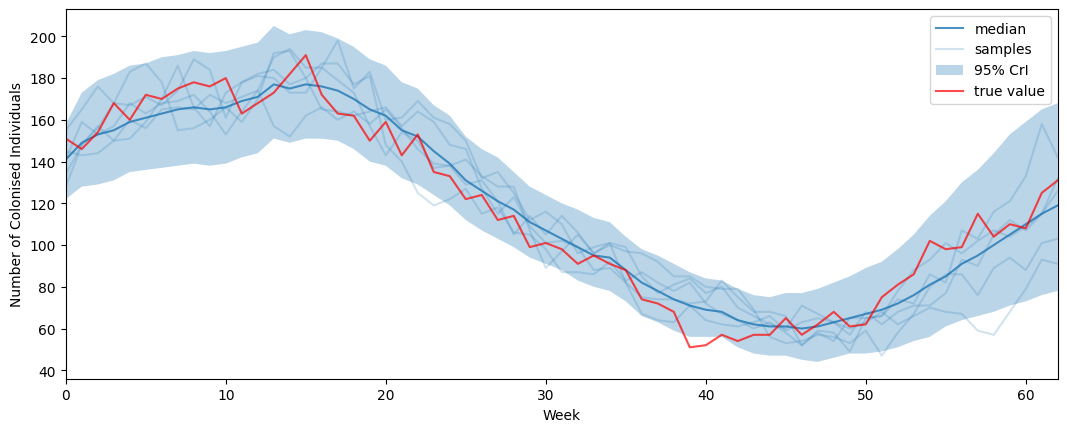

In [35]:
# 95% credible interval and median vs true (burn-in removed)
plt.figure(figsize=(12.8,4.8))
plt.plot(quantile_array[:,1], alpha=0.8, label="median")
plt.plot(random_path_0, alpha=0.2, color="tab:blue", label="samples")
plt.plot(random_path_1, alpha=0.2, color="tab:blue")
plt.plot(random_path_2, alpha=0.2, color="tab:blue")
plt.plot(random_path_3, alpha=0.2, color="tab:blue")
plt.plot(random_path_4, alpha=0.2, color="tab:blue")
plt.fill_between(range(T+1), quantile_array[:,0], quantile_array[:,2], alpha=0.3, label="95% CrI")
plt.plot(np.sum(UC_results['X'],axis=1), color="red", alpha=0.7, label="true value")
plt.legend(loc="upper right")
#plt.title("Number of Colonised Individuals (Burn-in Removed)")
plt.xlabel("Week")
plt.ylabel("Number of Colonised Individuals")
plt.xlim(0,62)
#plt.savefig("plots/colonised.pdf")
plt.show()

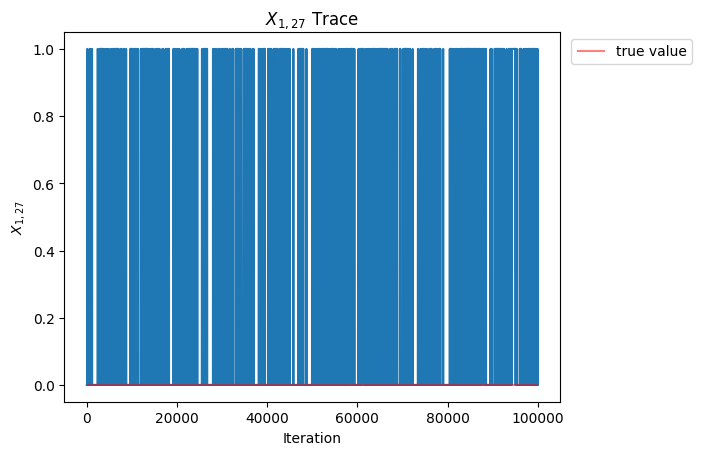

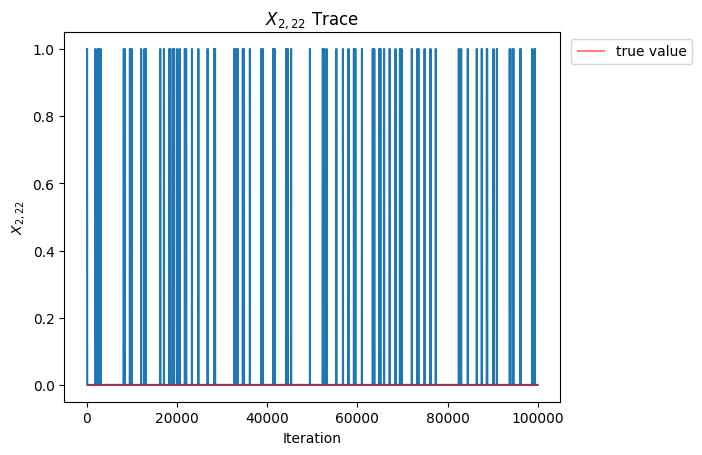

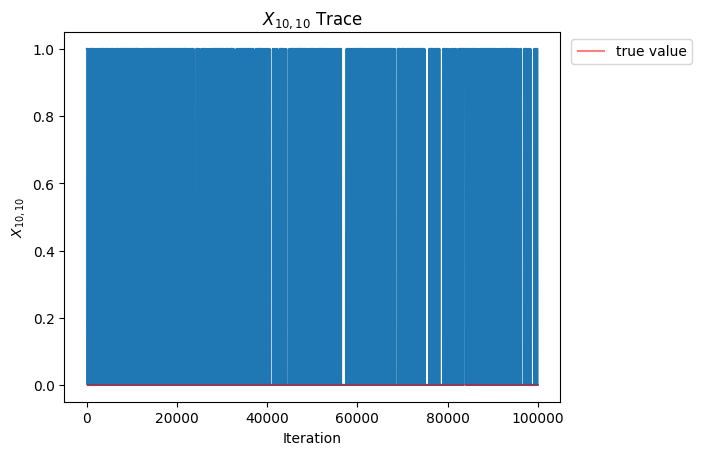

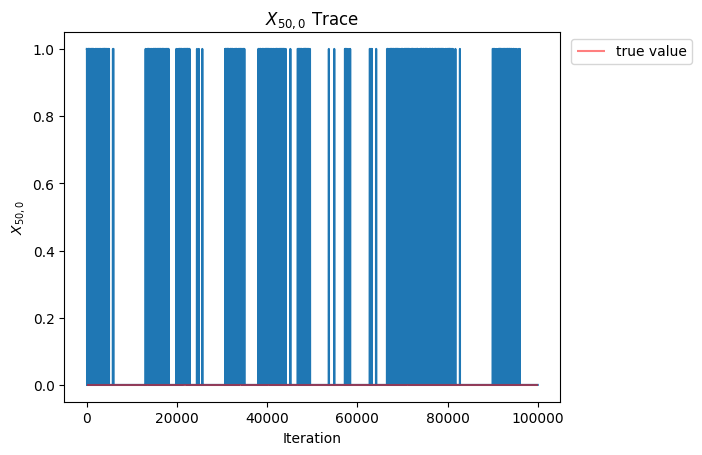

In [25]:
# importing the saved run of the X matrices resulting from the latent variables
MCMC_noncentred_X = zarr.open('./MCMC_output/X.zarr', mode='r')

# Trace plots of elements of X
plt.plot(MCMC_noncentred_X[:,1,27])
plt.hlines(UC_results['X'][1,27],0,K,colors="red",alpha=0.5,label="true value")
plt.legend(loc="upper right", bbox_to_anchor=(1.28, 1.0))
plt.title(r'$X_{1,27}$ Trace')
plt.xlabel("Iteration")
plt.ylabel(r'$X_{1,27}$')
plt.show()
plt.plot(MCMC_noncentred_X[:,2,22])
plt.hlines(UC_results['X'][2,22],0,K,colors="red",alpha=0.5,label="true value")
plt.legend(loc="upper right", bbox_to_anchor=(1.28, 1.0))
plt.title(r'$X_{2,22}$ Trace')
plt.xlabel("Iteration")
plt.ylabel(r'$X_{2,22}$')
plt.show()
plt.plot(MCMC_noncentred_X[:,10,10])
plt.hlines(UC_results['X'][10,10],0,K,colors="red",alpha=0.5,label="true value")
plt.legend(loc="upper right", bbox_to_anchor=(1.28, 1.0))
plt.title(r'$X_{10,10}$ Trace')
plt.xlabel("Iteration")
plt.ylabel(r'$X_{10,10}$')
plt.show()
plt.plot(MCMC_noncentred_X[:,50,0])
plt.hlines(UC_results['X'][50,0],0,K,colors="red",alpha=0.5,label="true value")
plt.legend(loc="upper right", bbox_to_anchor=(1.28, 1.0))
plt.title(r'$X_{50,0}$ Trace')
plt.xlabel("Iteration")
plt.ylabel(r'$X_{50,0}$')
plt.show()

# removing the traces of the latent variables from memory
del(MCMC_noncentred_X)

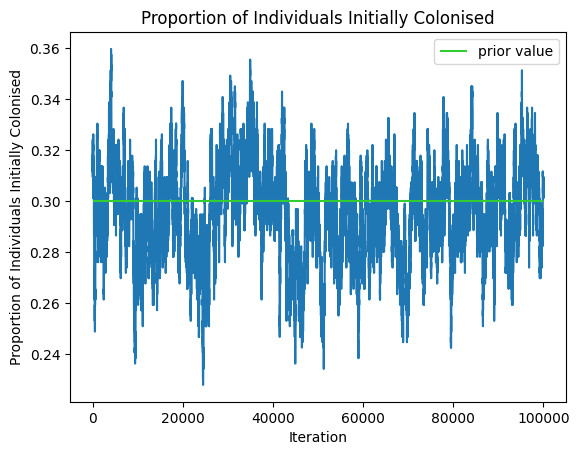

In [31]:
# importing the saved run of the X matrices resulting from the latent variables
MCMC_noncentred_X = zarr.open('./MCMC_output/X.zarr', mode='r')

# proportion of individuals colonised at time 0
plt.plot(np.average(MCMC_noncentred_X[:,0,:],axis=1))
#plt.hlines(np.average(UC_results['X'][0]),0,K,colors="red",label="true value")
plt.hlines(prior_X_0,0,K,colors="limegreen",label="prior value")
plt.legend(loc = "upper right")
plt.title("Proportion of Individuals Initially Colonised")
plt.xlabel("Iteration")
plt.ylabel("Proportion of Individuals Initially Colonised")
plt.show()

# removing the traces of the latent variables from memory
del(MCMC_noncentred_X)

In [25]:
# importing the saved run of the X matrices resulting from the latent variables
MCMC_noncentred_X = zarr.open('./MCMC_output/X.zarr', mode='r')

# calculating the MSJD for the final 1000 iterations
MSJD = 0
#MSJD += np.sum(np.absolute(X_start-MCMC_noncentred_X[0]))
for i in range(K-1-1000,K-1):
    print(i, end='\r')
    MSJD += np.sum(np.absolute(MCMC_noncentred_X[i]-MCMC_noncentred_X[i+1]))
#MSJD = MSJD/K
MSJD = MSJD/1000
print(MSJD)

# removing the traces of the latent variables from memory
del(MCMC_noncentred_X)

239.449


In [26]:
# importing the saved run of the X matrices resulting from the latent variables
MCMC_noncentred_X = zarr.open('../../../../luna/MCMC_noncentred_c29_v2/X.zarr', mode='r')

# calculating the MSJD for the final 90000 iterations
MSJD = np.zeros((T+1,N))
#MSJD += np.sum(np.absolute(X_start-MCMC_noncentred_X[0]))
for i in range(K-1-90000,K-1):
    MSJD += np.absolute(MCMC_noncentred_X[i]-MCMC_noncentred_X[i+1])
#MSJD = MSJD/K
MSJD = MSJD/90000
print(MSJD)

# printing the total MSJD
print(np.sum(MSJD))

# removing the traces of the latent variables from memory
del(MCMC_noncentred_X)

[[0.00095556 0.00162222 0.00094444 ... 0.00068889 0.00091111 0.00084444]
 [0.00142222 0.00062222 0.00146667 ... 0.012      0.01208889 0.01202222]
 [0.00855556 0.00971111 0.00917778 ... 0.01437778 0.01573333 0.016     ]
 ...
 [0.01013333 0.00917778 0.00942222 ... 0.00691111 0.00733333 0.00782222]
 [0.01073333 0.01073333 0.01075556 ... 0.00922222 0.01015556 0.011     ]
 [0.01046667 0.01113333 0.01046667 ... 0.00977778 0.01026667 0.01033333]]


## end